In [ ]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
%matplotlib inline
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import tables
import gc
import gzip
from scipy.sparse import coo_matrix
from sklearn.preprocessing import normalize
import pickle

### Load raw TCCs into memory

In [2]:
# tsvfile_dir = '/home/vasilis/clustering_EQ/10x_DATASETS/68k/RAW_READS/TCC_output/matrix.tsv'
# COOinput = pd.read_csv( tsvfile_dir, delimiter='\t',header=None, dtype=int)

# A=COOinput.as_matrix()

# rows,cols,data = A.T

In [3]:
# nonzero_ec = np.unique(rows)
# map_rows = { val:ind for ind,val in enumerate( nonzero_ec ) }
# map_cols = { val:ind for ind,val in enumerate( np.unique(cols) ) }
# TCCmatrix   = coo_matrix( (data.astype(float),( [map_rows[r] for r in rows], [map_cols[c] for c in cols]) ) ) 

# NUM_OF_CELLS = TCCmatrix.shape[1]
# print("NUM_OF_CELLS =", NUM_OF_CELLS)
      
# T = TCCmatrix.tocsr()
# # T_norm = normalize(T, norm='l1', axis=0) 
# # T_normT = T_norm.transpose()

In [4]:

# del TCCmatrix,map_cols,map_rows,A,rows,cols,data;
# _ = gc.collect()

In [5]:
# ecfile_dir = '/home/vasilis/clustering_EQ/10x_DATASETS/68k/RAW_READS/TCC_output/matrix.ec'
# eclist=pd.read_csv( ecfile_dir, delimiter='\t',header=None, dtype=str)


In [6]:
# #Save data
# with open("./TCC_matrix_68K.dat", 'wb') as f:
#     pickle.dump(T,f)
# with open("./nonzero_ec_68K.dat", 'wb') as f:
#     pickle.dump(nonzero_ec,f)
# with open("./eclist_68K.dat", 'wb') as f:
#     pickle.dump(eclist,f)

### Load pickled TCCs 

In [7]:
#Load dataset   
with open("./TCC_matrix_68K.dat", 'rb') as f:
    T=pickle.load(f)
with open("./nonzero_ec_68K.dat", 'rb') as f:
    nonzero_ec=pickle.load(f)
with open("./eclist_68K.dat", 'rb') as f:
    eclist=np.array(pickle.load(f))
    
# T_norm = normalize(T, norm='l1', axis=0)
# T_normT = T_norm.T   

### quality control

In [8]:
# median umis per cell
print("median UMIs per cell:",np.median(np.array((np.sum(T,axis=0))).reshape(1,-1)[0]))

median UMIs per cell: 4525.0


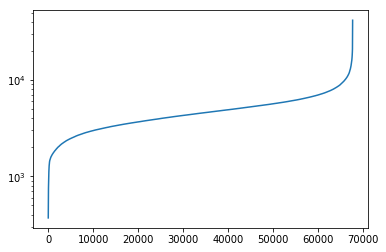

In [9]:
readspercell=np.array((np.sum(T,axis=0))).reshape(1,-1)[0]
plt.semilogy(np.sort(readspercell))

In [10]:
hi_low=[10000,3000]
cells_keep = np.where(readspercell<hi_low[0])[0]
idx = np.where(readspercell[cells_keep]>hi_low[1])[0]
cells_keep=cells_keep[idx]

In [11]:
cells_keep.shape

(55755,)

In [12]:
T=T[:,cells_keep]

###  ECdict

In [13]:
EC_dict = {}
for i in range(np.shape(eclist)[0]):
    EC_dict[i] = [int(x) for x in eclist[i,1].split(',')]
    
union=set()
for i in nonzero_ec:
    new = [tx for tx in EC_dict[i] if tx not in union] # filter out previously seen transcripts
    union.update(new) 
union_list=np.sort(list(union)) #union of all transctipt ids seen in nonzero eq.classes
NUM_OF_TX_inTCC = len(union)
print("NUM_OF_Transcripts =", NUM_OF_TX_inTCC) #number of distinct transcripts in nonzero eq. classes 

NUM_OF_Transcripts = 145388


In [14]:
path_to_ref='/home/vasilis/clustering_EQ/Human_reference/Homo_sapiens.GRCh38.rel79.cdna.all.fa.gz'

def readENS_ids(path_to_ref):
    TX_to_ENST={}
    TX_to_ENSG={}
    ENSG_isoforms={}
    line_cnt=0;
    tx_cnt=0;
    with gzip.open(path_to_ref) as f:
        for line in f:
            if line.decode('UTF-8')[0]=='>':
                liner=line.decode('UTF-8')
                if line_cnt == union_list[tx_cnt]:
                    TX_to_ENST[union_list[tx_cnt]] = 'ENST'+liner.split("ENST",1)[1][:11]
                    TX_to_ENSG[union_list[tx_cnt]] = 'ENSG'+liner.split("ENSG",1)[1][:11]
                    ENSG_isoforms[TX_to_ENSG[union_list[tx_cnt]]] = ENSG_isoforms.get(TX_to_ENSG[union_list[tx_cnt]], [])
                    ENSG_isoforms[TX_to_ENSG[union_list[tx_cnt]]].append(TX_to_ENST[union_list[tx_cnt]])
                    tx_cnt+=1 
                    if tx_cnt==NUM_OF_TX_inTCC: return [TX_to_ENST,TX_to_ENSG,ENSG_isoforms]
                line_cnt+=1
    return [TX_to_ENST,TX_to_ENSG,ENSG_isoforms]


[TX_to_ENST,TX_to_ENSG,ENSG_isoforms]=readENS_ids(path_to_ref)       

In [15]:
EC_ENST_DICT={}
EC_ENSG_DICT={}
for ec in nonzero_ec:
    EC_ENST_DICT[ec] = [TX_to_ENST[tx] for tx in EC_dict[ec]]    
    EC_ENSG_DICT[ec] = list(np.unique([TX_to_ENSG[tx] for tx in EC_dict[ec]])) 

In [16]:
ENST_to_TX = {v: k for k, v in TX_to_ENST.items()}

In [17]:
#inv_map ; NOTE: genes and transcripts may be associated with multiple ensg accession numbers
ENSG_EC_DICT={}
for k, v in EC_ENSG_DICT.items():
    for vi in v:
        ENSG_EC_DICT[vi] = ENSG_EC_DICT.get(vi, [])
        ENSG_EC_DICT[vi].append(k)
        
ENST_EC_DICT={}
for k, v in EC_ENST_DICT.items():
    for vi in v:
        ENST_EC_DICT[vi] = ENST_EC_DICT.get(vi, [])
        ENST_EC_DICT[vi].append(k)

In [18]:
all_genes_ids = np.unique(list(TX_to_ENSG.values()))
print("NUM_OF_GENE_IDs =", len(all_genes_ids))

NUM_OF_GENE_IDs = 28507


#### gene names

In [19]:
# #gene ids to gene names (requires "pip install mygene")
# import mygene
# mg = mygene.MyGeneInfo()
# ginfo = mg.querymany(all_genes_ids, scopes='ensembl.gene',returnall=True)

# with open('ginfo_68_all.pickle', 'wb') as handle:
#     pickle.dump(ginfo, handle, protocol=pickle.HIGHEST_PROTOCOL)

#LOAD
with open('ginfo_68_all.pickle', 'rb') as handle:
    ginfo = pickle.load(handle)

In [20]:
missing_names=ginfo['missing']
duplicate_names=ginfo['dup']

In [21]:
#ENSG to Gene-Names
all_gene_id_to_names={} #missing are mapped to their ENSG id, Duplicates to a list of names
count_exept=0
for g in ginfo['out']:
    try:
        ensg_id=str(g['query'])
        all_gene_id_to_names[ensg_id] = all_gene_id_to_names.get(ensg_id, [])
        all_gene_id_to_names[ ensg_id].append(str(g['symbol']))                
    except KeyError:
        count_exept=count_exept+1
        all_gene_id_to_names[ str(g['query']) ] = [str(g['query'])]
        
#Gene-Names to ENSG
all_gene_names_to_id={} #missing are mapped to their ENSG id, Duplicates to a list of names
count_exept=0
for g in ginfo['out']:
    try:
        gene_name=str(g['symbol'])
        all_gene_names_to_id[gene_name] = all_gene_names_to_id.get(gene_name, [])
        all_gene_names_to_id[ gene_name].append(str(g['query']))                
    except KeyError:
        count_exept=count_exept+1
        all_gene_names_to_id[ str(g['query']) ] = [str(g['query'])]

In [22]:
def search_gene(starting_letters):
    print("SEARCHING: ",starting_letters,"...")
    for gene in all_genes_ids:
        if all_gene_id_to_names[gene][0][:len(starting_letters)] == starting_letters:
            print(gene,all_gene_id_to_names[gene])
    print("DONE")

In [23]:
EC_IDX={}
for i in range(len(nonzero_ec)):
    EC_IDX[nonzero_ec[i]] =i 

### gene counts ec filter

In [37]:
gnames=np.unique(np.array(list(all_gene_names_to_id.keys())))
print(len(gnames))

26263


In [68]:
# %%time
# clean_ecs=[]
# for gene in gnames:

#     gene_ecs0=[]
#     for g in all_gene_names_to_id[gene]:
#         gene_ecs0+=ENSG_EC_DICT[g]
#     gene_ecs0=np.unique(gene_ecs0)

#     ec_counts=[]
#     for ec in gene_ecs0:
#         ec_counts+=[T[EC_IDX[ec],:].sum()]

#     argsrt=np.argsort(ec_counts)[::-1]

#     firstk=1
#     gene_ecs = gene_ecs0[argsrt[:firstk]]
#     associated_genes=[]
#     for ec in gene_ecs:
#         associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
#     associated_genes=np.unique(associated_genes)

#     while len(associated_genes)==1:
#         firstk=firstk+1
#         if firstk==len(argsrt)+1: break
#         gene_ecs = gene_ecs0[argsrt[:firstk]]
#         associated_genes=[]
#         for ec in gene_ecs:
#             associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
#         associated_genes=np.unique(associated_genes)
        
#     if firstk>1:firstk-=1
#     gene_ecs=gene_ecs0[argsrt[:firstk]]
#     if len(gene_ecs)>0:
#         associated_genes=[]
#         for ec in gene_ecs:
#             associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
#         associated_genes=np.unique(associated_genes)
#     if len(associated_genes)==1: clean_ecs+=list(gene_ecs)
    

# clean_ecs=np.unique(clean_ecs)

In [90]:
# #SAVE
# with open("./clean_ecs_68K.dat", 'wb') as f:
#     pickle.dump(clean_ecs,f)

In [ ]:
#LOAD
with open("./clean_ecs_68K.dat", 'rb') as f:
    clean_ecs=np.array(pickle.load(f))

In [69]:
len(clean_ecs)

95426

In [71]:
ec_indices=np.array([EC_IDX[ec] for ec in clean_ecs])
len(ec_indices)

95426

In [72]:
Tclust=T[ec_indices,:]

## scanpy

In [73]:
import scanpy.api as sc
sc.settings.verbosity = 3                # increase for more output
sc.settings.set_dpi(200)                  # low pixel number yields small inline figures
sc.logging.print_version_and_date()

/home/vasilis/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Running Scanpy version 0.2.6 on 2017-10-29 03:24.


In [74]:
adata=sc.AnnData(Tclust.T)
adata.var_names=clean_ecs


In [75]:
sc.write('68K_TCC_6000000000raw', adata) # raw counts

writing ./write/68K_TCC_6000000000raw.h5


In [76]:
adata=sc.read('68K_TCC_6000000000raw')
adata

reading file ./write/68K_TCC_6000000000raw.h5


AnnData object with n_smps x n_vars = 55755 x 95426
    smp_keys = []
    var_keys = []
    add_keys = ['smp_keys_multicol', 'var_keys_multicol']
    smp_names = ['0' '1' '2' ..., '55752' '55753' '55754']
    var_names = ['41' '42' '43' ..., '828485' '828542' '828561']

In [79]:
%%time
sc.pp.filter_genes(adata, min_counts=50)  # only consider genes with more than 1 count
sc.pp.normalize_per_cell(adata)          # normalize with total UMI count per cell

filter_result = sc.pp.filter_genes_dispersion(adata.X, flavor='cell_ranger', n_top_genes=5000, log=False)

CPU times: user 4.8 s, sys: 1.34 s, total: 6.14 s
Wall time: 6.14 s


/home/vasilis/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/scale.py:103: RuntimeWarning: divide by zero encountered in log
  return np.divide(np.log(a, out=a), np.log(self.base), out=a)


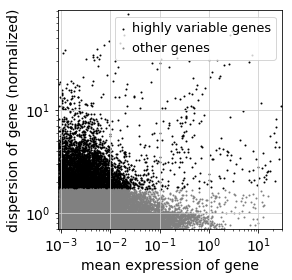

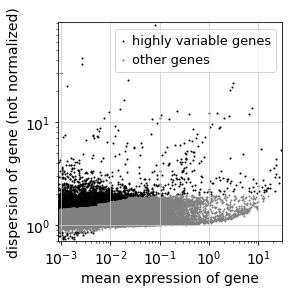

In [80]:
# PLOT SELECTED GENES
sc.pl.filter_genes_dispersion(filter_result, log=True)

In [81]:
%%time
adata = adata[:, filter_result.gene_subset]  # filter genes
sc.pp.normalize_per_cell(adata)  # need to redo normalization after filtering

sc.pp.log1p(adata)  # log transform: X = log(X + 1)

sc.pp.scale(adata)

CPU times: user 1.51 s, sys: 636 ms, total: 2.15 s
Wall time: 2.15 s


In [82]:
%%time
sc.tl.pca(adata, n_comps=50)

CPU times: user 1min 50s, sys: 4.8 s, total: 1min 55s
Wall time: 22.6 s


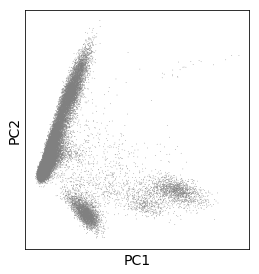

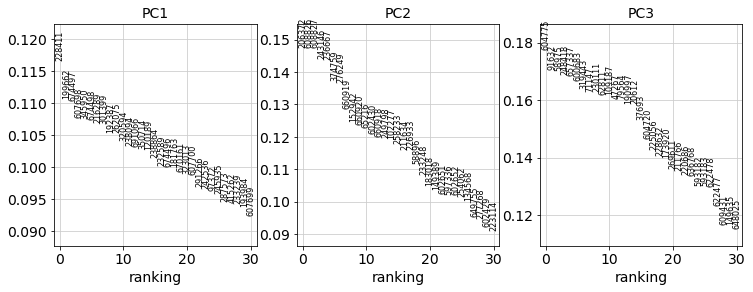

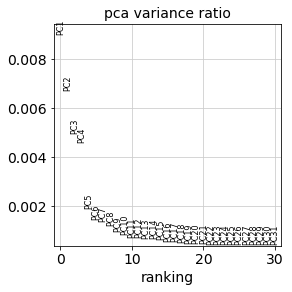

In [83]:
sc.pl.pca(adata)

In [84]:
from tsne import bh_sne

In [85]:
%%time
# X_tsne = bh_sne(adata.smp['X_pca'].astype("float64"))
X_tsne = bh_sne(adata.smp['X_pca'].astype("float64"),theta=0.3)

CPU times: user 8min 33s, sys: 1.42 s, total: 8min 34s
Wall time: 8min 34s


In [86]:
adata.smp['X_tsne'] = X_tsne
sc.logging.print_memory_usage()

Memory usage: current 5.42 GB, difference +5.42 GB


In [87]:
### SAVE current adata
sc.write('68K_TCC_600000000filt', adata)

writing ./write/68K_TCC_600000000filt.h5


### Clustering

In [161]:
%%time
adata=sc.read('68K_TCC_600000000filt')
sc.tl.louvain(adata, resolution=1.5,recompute_pca=False,n_jobs=16)
sc.logging.print_memory_usage()

reading file ./write/68K_TCC_600000000filt.h5
running Louvain clustering
    using "X_pca" for building graph
    computing data graph with n_neighbors = 30 
    using "X_pca" for building graph
    computing spectral decomposition ("diffmap") with 15 components
    eigenvalues of transition matrix
    [ 1.            0.9971544147  0.9950734377  0.9888751507  0.980378449
      0.978690207   0.9783419967  0.9779256582  0.9774932265  0.9760783911
      0.9749643803  0.9721230268  0.9716947675  0.9699193239  0.9697040319]
    using the "louvain" package of Traag (2017)
    finished (0:01:34.715) and found 49 clusters, added
    "louvain_groups", the cluster labels (adata.smp)
    "louvain_groups_names", the unique cluster labels (adata.add)
Memory usage: current 8.71 GB, difference -0.00 GB
CPU times: user 6min, sys: 3min 26s, total: 9min 26s
Wall time: 1min 35s


In [163]:
labels=adata.smp['louvain_groups']

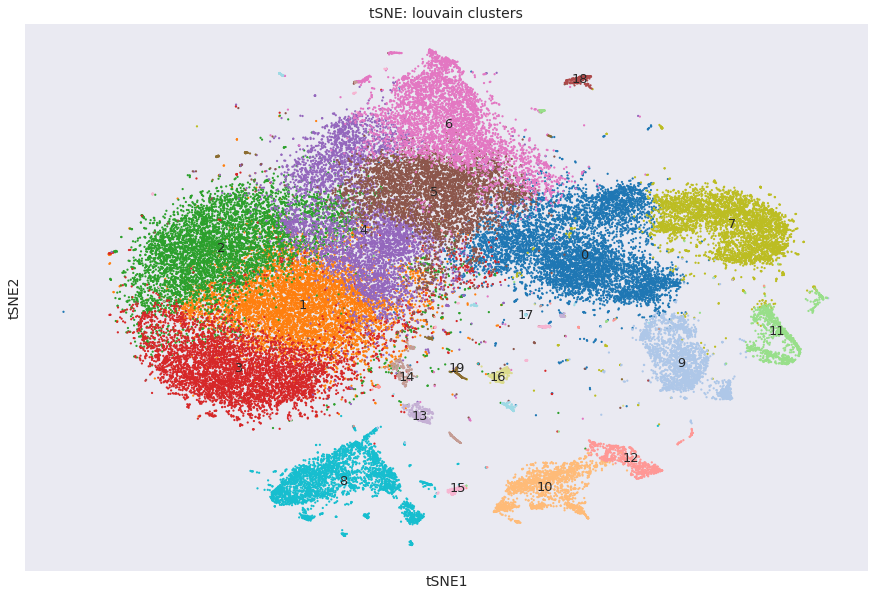

In [287]:
tmp=np.array([int(i) for i in labels])
idx=np.where(tmp<20)[0]

bdata=sc.AnnData(adata.X[idx,:])
bdata.smp['X_pca'] = adata.smp['X_pca'][idx,:]
bdata.smp['X_tsne'] = adata.smp['X_tsne'][idx,:]
bdata.smp['louvain_groups'] = adata.smp['louvain_groups'][idx]
bdata.var_names=adata.var_names

plt.figure(figsize=(15,10))
ax=plt.gca()
ax1=sc.pl.tsne(bdata, color=['louvain_groups'], legend_loc='on data',title='tSNE: louvain clusters',ax=ax,size=20,show=False)

In [164]:
def get_gene_counts(gene,printer=False):
    gene_ecs0=[]
    for g in all_gene_names_to_id[gene]:
        gene_ecs0+=ENSG_EC_DICT[g]
    gene_ecs0=np.unique(gene_ecs0)

    ec_counts=[]
    for ec in gene_ecs0:
        ec_counts+=[T[EC_IDX[ec],:].sum()]
        
    sns.set_style("darkgrid")

    # threshold=0.0005*T.shape[1]
    argsrt=np.argsort(ec_counts)[::-1]

    firstk=len(argsrt)
    gene_ecs = gene_ecs0[argsrt[:firstk]]
    associated_genes=[]
    for ec in gene_ecs:
        associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
    associated_genes=np.unique(associated_genes)

    while len(associated_genes)>1:
        firstk=firstk-1
        gene_ecs = gene_ecs0[argsrt[:firstk]]
        associated_genes=[]
        for ec in gene_ecs:
            associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
        associated_genes=np.unique(associated_genes)

    
    gene_ecs=gene_ecs0[argsrt[:firstk]]
    upto=len(gene_ecs)

    if printer:
        print(firstk)
        plt.figure(figsize=(8,5))
        plt.stem(range(len(ec_counts)),np.sort(ec_counts)[::-1],'gray',markerfmt='.')

        plt.xticks(range(len(ec_counts)),gene_ecs0[np.argsort(ec_counts)[::-1]],rotation='vertical',fontsize=10)
        # plt.xlim([0,len(b)+0.9])

        plt.stem(range(upto),np.sort(ec_counts)[::-1][:upto])

        # plt.axhline(y=threshold, color='darkred', linestyle='--',linewidth=1)
        plt.xlabel("equivalence classes",fontsize=16)
        plt.ylabel("umi counts",fontsize=16)
        plt.yscale('log')
        plt.show()
    
    ecidx=np.array([EC_IDX[ec] for ec in gene_ecs])
    return np.array(T[ecidx,:].todense().sum(axis=0)[0].reshape(1,-1))[0]
    
    

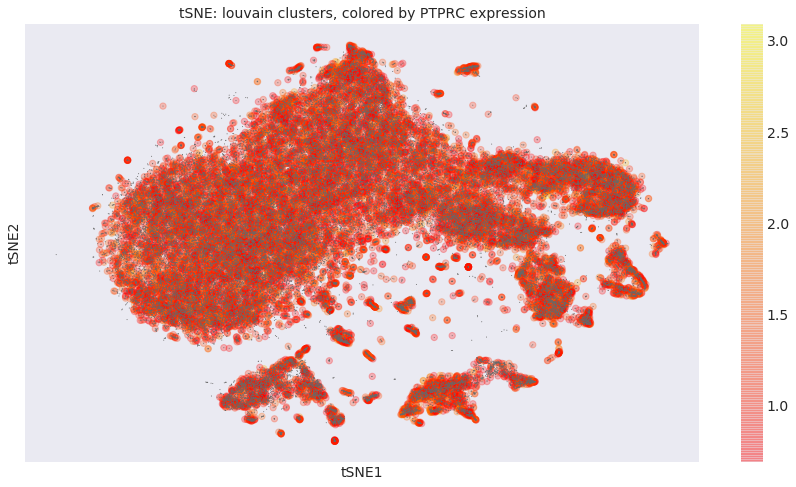

In [288]:
gene="PTPRC"
Gexp=get_gene_counts(gene)

fig=plt.figure(figsize=(15,8))
ax=plt.gca()

col=np.log(1+Gexp[idx])
# mini=-0.101633
mini=np.median(col)
im=plt.scatter(bdata.smp['X_tsne'][np.where(col>mini)[0],0],bdata.smp['X_tsne'][np.where(col>mini)[0],1],s=40,alpha=0.25,c=col[np.where(col>mini)[0]],cmap='autumn')
ax1=sc.pl.tsne(bdata, color='dimgray', legend_loc='on data',title=['tSNE: louvain clusters, colored by '+gene+' expression'],ax=ax,size=4,show=False)
fig.colorbar(im, cmap='autumn', orientation='vertical')

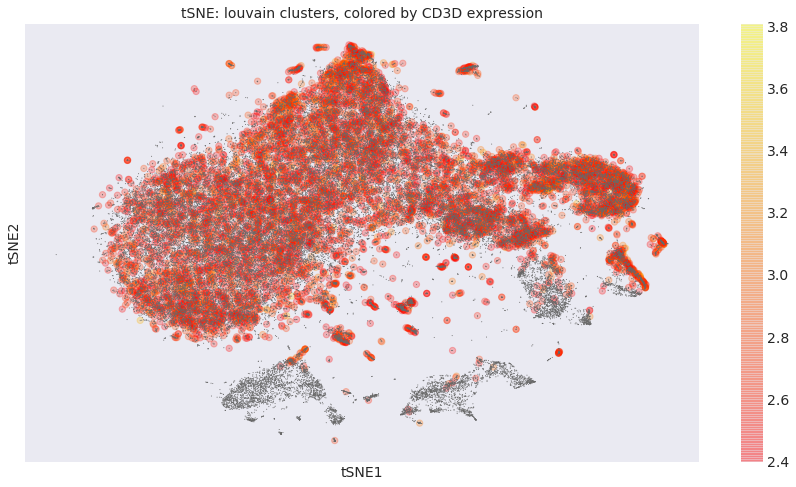

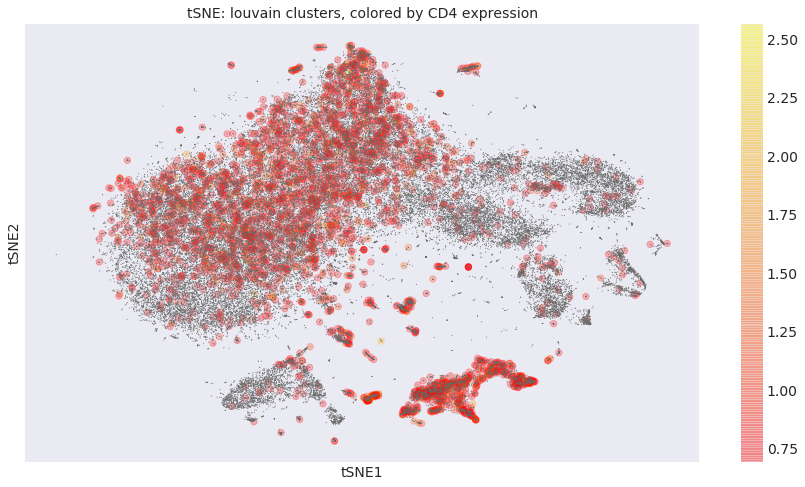

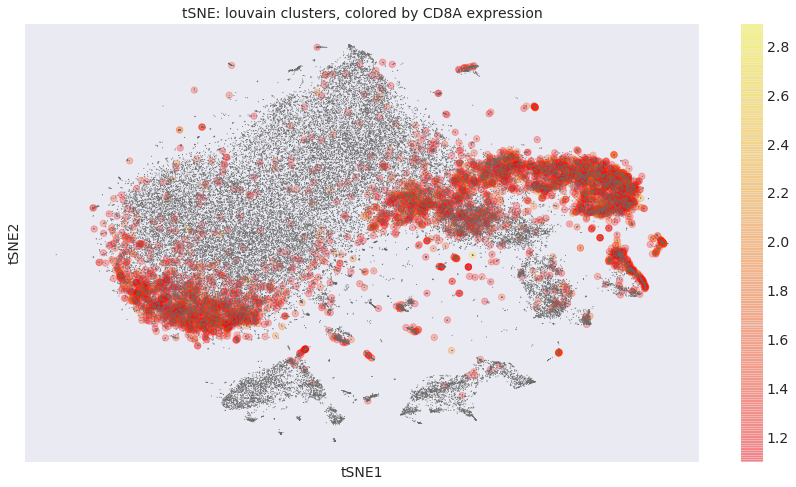

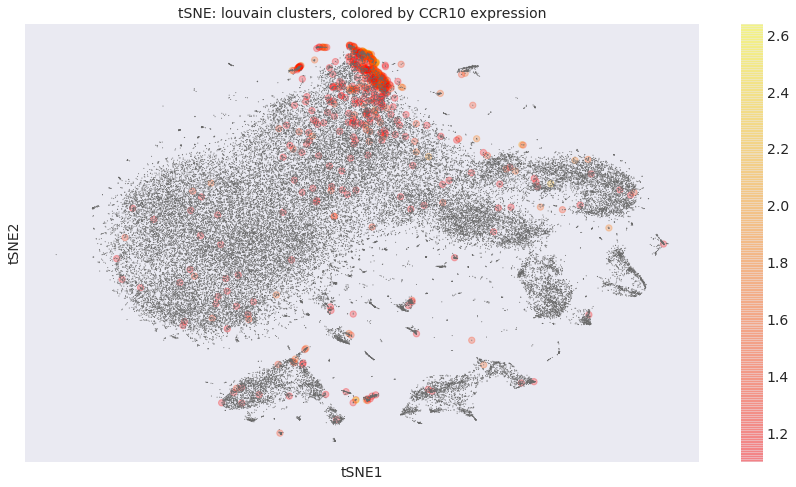

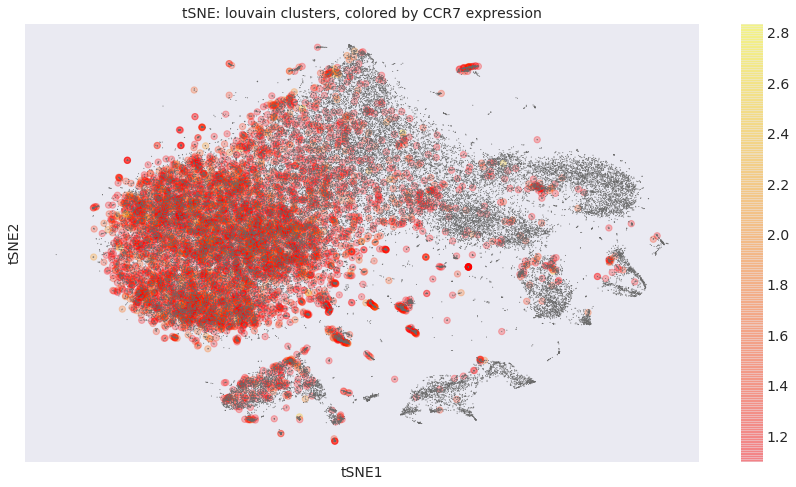

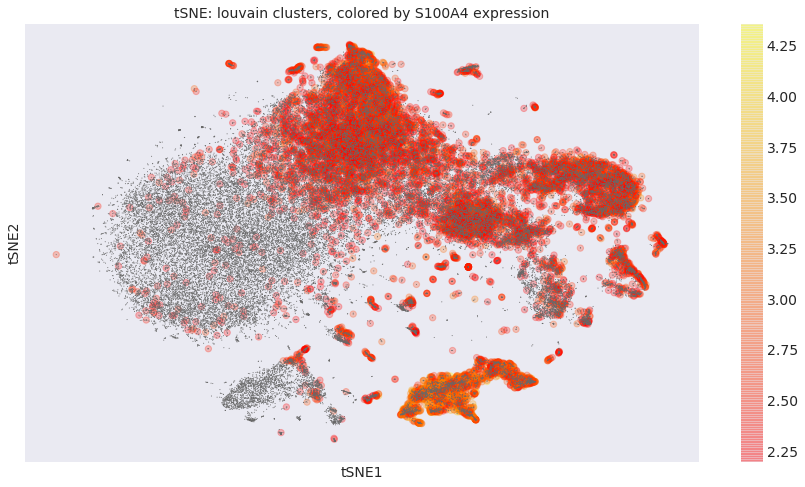

In [298]:
gene="CD3D"
Gexp=get_gene_counts(gene)

fig=plt.figure(figsize=(15,8))
ax=plt.gca()

col=np.log(1+Gexp[idx])
# mini=-0.101633
mini=1+np.median(col)
im=plt.scatter(bdata.smp['X_tsne'][np.where(col>mini)[0],0],bdata.smp['X_tsne'][np.where(col>mini)[0],1],s=40,alpha=0.25,c=col[np.where(col>mini)[0]],cmap='autumn')
ax1=sc.pl.tsne(bdata, color='dimgray', legend_loc='on data',title=['tSNE: louvain clusters, colored by '+gene+' expression'],ax=ax,size=4,show=False)
fig.colorbar(im, cmap='autumn', orientation='vertical')

gene="CD4"
Gexp=get_gene_counts(gene)

fig=plt.figure(figsize=(15,8))
ax=plt.gca()

col=np.log(1+Gexp[idx])
# mini=-0.101633
mini=np.median(col)
im=plt.scatter(bdata.smp['X_tsne'][np.where(col>mini)[0],0],bdata.smp['X_tsne'][np.where(col>mini)[0],1],s=40,alpha=0.25,c=col[np.where(col>mini)[0]],cmap='autumn')
ax1=sc.pl.tsne(bdata, color='dimgray', legend_loc='on data',title=['tSNE: louvain clusters, colored by '+gene+' expression'],ax=ax,size=4,show=False)
fig.colorbar(im, cmap='autumn', orientation='vertical')

gene="CD8A"
Gexp=get_gene_counts(gene)

fig=plt.figure(figsize=(15,8))
ax=plt.gca()

col=np.log(1+Gexp[idx])
# mini=-0.101633
mini=1+np.median(col)
im=plt.scatter(bdata.smp['X_tsne'][np.where(col>mini)[0],0],bdata.smp['X_tsne'][np.where(col>mini)[0],1],s=40,alpha=0.25,c=col[np.where(col>mini)[0]],cmap='autumn')
ax1=sc.pl.tsne(bdata, color='dimgray', legend_loc='on data',title=['tSNE: louvain clusters, colored by '+gene+' expression'],ax=ax,size=4,show=False)
fig.colorbar(im, cmap='autumn', orientation='vertical')

gene="CCR10"
Gexp=get_gene_counts(gene)

fig=plt.figure(figsize=(15,8))
ax=plt.gca()

col=np.log(1+Gexp[idx])
# mini=-0.101633
mini=1+np.median(col)
im=plt.scatter(bdata.smp['X_tsne'][np.where(col>mini)[0],0],bdata.smp['X_tsne'][np.where(col>mini)[0],1],s=40,alpha=0.25,c=col[np.where(col>mini)[0]],cmap='autumn')
ax1=sc.pl.tsne(bdata, color='dimgray', legend_loc='on data',title=['tSNE: louvain clusters, colored by '+gene+' expression'],ax=ax,size=4,show=False)
fig.colorbar(im, cmap='autumn', orientation='vertical')

gene="CCR7"
Gexp=get_gene_counts(gene)

fig=plt.figure(figsize=(15,8))
ax=plt.gca()

col=np.log(1+Gexp[idx])
# mini=-0.101633
mini=1+np.median(col)
im=plt.scatter(bdata.smp['X_tsne'][np.where(col>mini)[0],0],bdata.smp['X_tsne'][np.where(col>mini)[0],1],s=40,alpha=0.25,c=col[np.where(col>mini)[0]],cmap='autumn')
ax1=sc.pl.tsne(bdata, color='dimgray', legend_loc='on data',title=['tSNE: louvain clusters, colored by '+gene+' expression'],ax=ax,size=4,show=False)
fig.colorbar(im, cmap='autumn', orientation='vertical')

gene="S100A4"
Gexp=get_gene_counts(gene)

fig=plt.figure(figsize=(15,8))
ax=plt.gca()

col=np.log(1+Gexp[idx])
# mini=-0.101633
mini=1+np.median(col)
im=plt.scatter(bdata.smp['X_tsne'][np.where(col>mini)[0],0],bdata.smp['X_tsne'][np.where(col>mini)[0],1],s=40,alpha=0.25,c=col[np.where(col>mini)[0]],cmap='autumn')
ax1=sc.pl.tsne(bdata, color='dimgray', legend_loc='on data',title=['tSNE: louvain clusters, colored by '+gene+' expression'],ax=ax,size=4,show=False)
fig.colorbar(im, cmap='autumn', orientation='vertical')

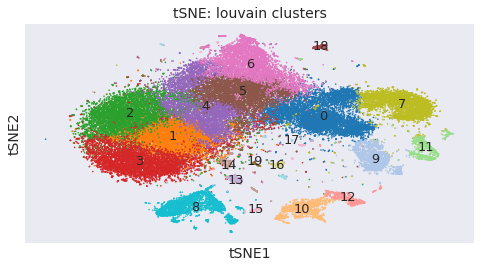

In [290]:
plt.figure(figsize=(8,4))
ax=plt.gca()

ax1=sc.pl.tsne(bdata, color=['louvain_groups'], legend_loc='on data',title='tSNE: louvain clusters',ax=ax,size=10,show=False)

In [206]:
labels_orig=labels

In [207]:
merge_labels=[]
for i in labels:
    if i=='2':
        merge_labels+=['1']
    else:
        merge_labels+=[i]

In [208]:
labels=np.array(merge_labels)

# LOGR

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import statsmodels.api as sm
from scipy import stats
import math

In [104]:
def logr_ecidx(ecidx,X1,X2):
    
    N1=X1.shape[0]
    N2=X2.shape[0]
    logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)
    logr = LogisticRegression()
    p_of_1=N1/float(N1+N2)
    llnull=(N1+N2)*(p_of_1*np.log(p_of_1) + (1-p_of_1)*np.log(1-p_of_1))
    k=len(ecidx)
    
    X1_ecidx=X1[:,ecidx].todense()
    X2_ecidx=X2[:,ecidx].todense()
    c=np.concatenate([X1_ecidx,X2_ecidx])
    #c=np.concatenate([X1[:,ecidx],X2[:,ecidx]])
    logr.fit(c,logr_labels)
    pred=np.array(logr.predict_proba(c)[:,1])
    gene_score=log_loss(logr_labels,pred)
    llf=-gene_score*(N1+N2)
    llr=llf-llnull
    llr_pval = 1-stats.chi2.cdf(2*llr,k)
    
    return [logr,llr_pval]

In [105]:
Adata=sc.read('68K_TCC_6000000000raw')

reading file ./write/68K_TCC_6000000000raw.h5


In [209]:
mem_id='6'
naive_id='1'
cyto_id='3'

subgroups=[cyto_id,naive_id,naive_id]

subidx=[]
for i in range(len(labels)):
    if labels[i] in subgroups:
        subidx=subidx+[i] 
subidx=np.array(subidx)

In [210]:
T0=T[:,subidx]

## PTPRC

In [243]:
gene="PTPRC"
all_gene_names_to_id[gene]

['ENSG00000081237', 'ENSG00000262418']

In [212]:
gene_ecs0=[]
for g in all_gene_names_to_id[gene]:
    gene_ecs0+=ENSG_EC_DICT[g]
gene_ecs0=np.unique(gene_ecs0)

ec_counts=[]
for ec in gene_ecs0:
    ec_counts+=[T0[EC_IDX[ec],:].sum()]
ec_nnz_cell_counts=[]
for ec in gene_ecs0:
    ec_nnz_cell_counts+=[T0[EC_IDX[ec],:].nnz] 
    

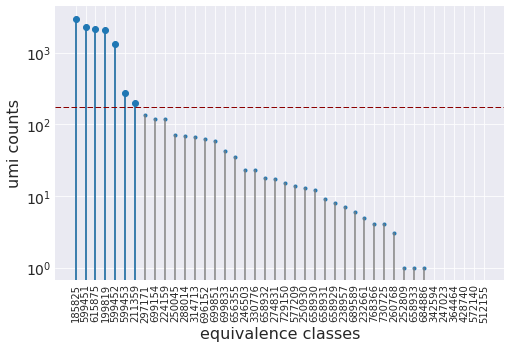

In [213]:
sns.set_style("darkgrid")

threshold=0.01*T0.shape[1]

gene_ecs=gene_ecs0[np.where(np.array(ec_counts)>threshold)[0]]
upto=len(gene_ecs)

plt.figure(figsize=(8,5))
plt.stem(range(len(ec_counts)),np.sort(ec_counts)[::-1],'gray',markerfmt='.')

plt.xticks(range(len(ec_counts)),gene_ecs0[np.argsort(ec_counts)[::-1]],rotation='vertical',fontsize=10)
# plt.xlim([0,len(b)+0.9])

plt.stem(range(upto),np.sort(ec_counts)[::-1][:upto])

plt.axhline(y=threshold, color='darkred', linestyle='--',linewidth=1)
plt.xlabel("equivalence classes",fontsize=16)
plt.ylabel("umi counts",fontsize=16)
plt.yscale('log')
plt.show()

In [214]:
associated_genes=[]
for ec in gene_ecs:
    associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
associated_genes=np.unique(associated_genes)
print(associated_genes)

['PTPRC']


In [215]:
ecidx=np.array([EC_IDX[ec] for ec in gene_ecs])

In [216]:
print(ecidx)

[ 78063  87193  94634 280031 280032 280033 290723]


In [217]:
eq_classes=[]
for i in ecidx:
    tx_indices=EC_dict[nonzero_ec[i]]
    tx_ens=[TX_to_ENST[t] for t in tx_indices]
    eq_classes+=[tx_ens]

In [218]:
import json
eq_dict={}
for i in range(len(eq_classes)):
    eq_dict[str(nonzero_ec[ecidx[i]])] = list(np.sort(eq_classes[i]))
print(json.dumps(eq_dict, indent=1))

{
 "185825": [
  "ENST00000348564",
  "ENST00000442510"
 ],
 "199819": [
  "ENST00000348564",
  "ENST00000367367",
  "ENST00000442510",
  "ENST00000529828",
  "ENST00000530727",
  "ENST00000573477",
  "ENST00000573679",
  "ENST00000574441",
  "ENST00000575923",
  "ENST00000576833"
 ],
 "211359": [
  "ENST00000413409",
  "ENST00000571847"
 ],
 "599451": [
  "ENST00000348564",
  "ENST00000367367",
  "ENST00000442510",
  "ENST00000529828"
 ],
 "599452": [
  "ENST00000348564",
  "ENST00000367367",
  "ENST00000442510",
  "ENST00000529828",
  "ENST00000530727"
 ],
 "599453": [
  "ENST00000348564",
  "ENST00000367367",
  "ENST00000442510",
  "ENST00000491302",
  "ENST00000529828",
  "ENST00000530727",
  "ENST00000573477",
  "ENST00000573679",
  "ENST00000574441",
  "ENST00000575803",
  "ENST00000575923",
  "ENST00000576833"
 ],
 "615875": [
  "ENST00000348564",
  "ENST00000367367",
  "ENST00000367379",
  "ENST00000442510",
  "ENST00000529828",
  "ENST00000530727",
  "ENST00000573298",
  "ENST

In [219]:
sns.set_style("white")

In [220]:
X=T.T

In [240]:
Xclust1=X[np.squeeze(labels==naive_id),:]
Xclust2=X[np.squeeze(labels==mem_id),:]

print(Xclust1.shape)
print(Xclust2.shape)

(12424, 468143)
(4173, 468143)


In [241]:
np.random.seed(0)
samples=2000


randperm1=np.random.permutation(Xclust1.shape[0])
randperm2=np.random.permutation(Xclust2.shape[0])

(2000, 468143)
(2000, 468143)
pval= 0.000107714218167


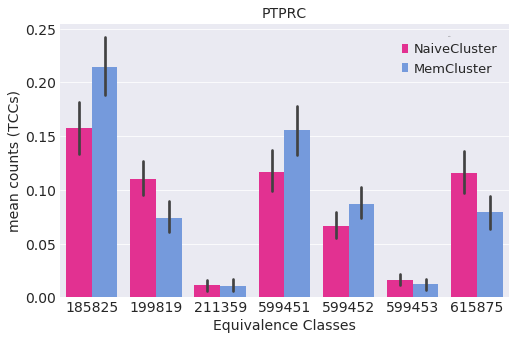

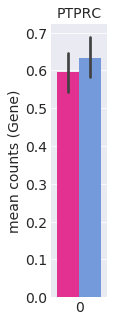

In [244]:
#positive control 

X1=Xclust1[randperm1[:samples],:]
X2=Xclust2[randperm2[:samples],:]


print(X1.shape)
print(X2.shape)

N1=X1.shape[0]
N2=X2.shape[0]


A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])


X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()

P1=pd.DataFrame(X1_ecidx,columns=nonzero_ec[ecidx])
P1['cluster'] = 'NaiveCluster'
P2=pd.DataFrame(X2_ecidx,columns=nonzero_ec[ecidx])
P2['cluster'] = 'MemCluster'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#6495ED"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()


Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'NaiveCluster'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'MemCluster'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#6495ED"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()

In [245]:
Xclust1=X[np.squeeze(labels==naive_id),:]
Xclust2=X[np.squeeze(labels==cyto_id),:]

print(Xclust1.shape)
print(Xclust2.shape)


(12424, 468143)
(5226, 468143)


In [248]:
np.random.seed(0)
samples=2000
# samples=9923 #full dataset

randperm2=np.random.permutation(Xclust2.shape[0])
randperm1=np.random.permutation(Xclust1.shape[0])


(2000, 468143)
(2000, 468143)
pval= 0.84135412165


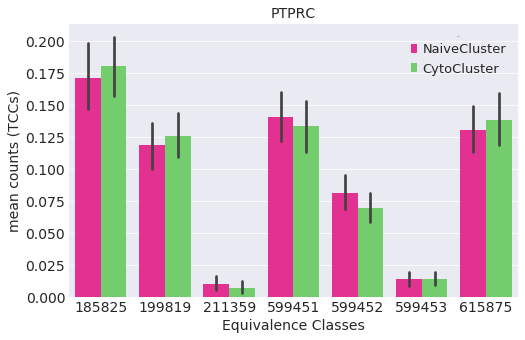

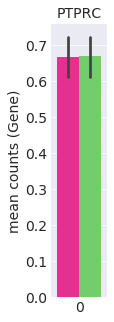

In [249]:
#positive control 

X1=Xclust1[randperm1[:samples],:]
X2=Xclust2[randperm2[:samples],:]


print(X1.shape)
print(X2.shape)

N1=X1.shape[0]
N2=X2.shape[0]


A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])


X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()

P1=pd.DataFrame(X1_ecidx,columns=nonzero_ec[ecidx])
P1['cluster'] = 'NaiveCluster'
P2=pd.DataFrame(X2_ecidx,columns=nonzero_ec[ecidx])
P2['cluster'] = 'CytoCluster'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#66dd5c"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()


Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'NaiveCluster'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'CytoCluster'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#66dd5c"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()

In [250]:
Xclust1=X[np.squeeze(labels==cyto_id),:]
Xclust2=X[np.squeeze(labels==mem_id),:]

print(Xclust1.shape)
print(Xclust2.shape)

(5226, 468143)
(4173, 468143)


In [251]:
np.random.seed(0)
samples=2000
# samples=9923 #full dataset

randperm1=np.random.permutation(Xclust1.shape[0])
randperm2=np.random.permutation(Xclust2.shape[0])

(2000, 468143)
(2000, 468143)
pval= 6.61587073735e-05


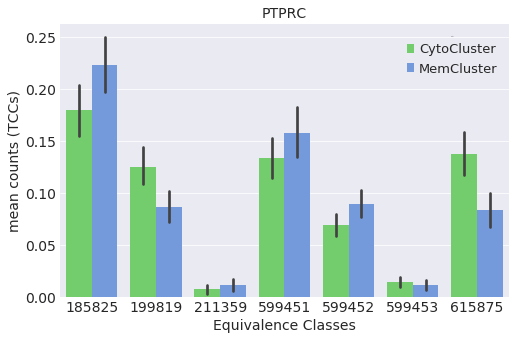

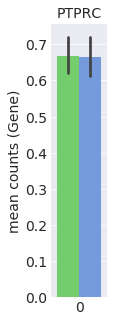

In [252]:
#positive control 

X1=Xclust1[randperm1[:samples],:]
X2=Xclust2[randperm2[:samples],:]


print(X1.shape)
print(X2.shape)

N1=X1.shape[0]
N2=X2.shape[0]


A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])


X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()

P1=pd.DataFrame(X1_ecidx,columns=nonzero_ec[ecidx])
P1['cluster'] = 'CytoCluster'
P2=pd.DataFrame(X2_ecidx,columns=nonzero_ec[ecidx])
P2['cluster'] = 'MemCluster'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#66dd5c", "#6495ED"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()


Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'CytoCluster'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'MemCluster'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#66dd5c", "#6495ED"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()

### cyto vs naive

In [303]:
X_naive=X[np.squeeze(labels==naive_id),:]
X_cyto=X[np.squeeze(labels==cyto_id),:]

print(X_naive.shape)
print(X_cyto.shape)

(12424, 468143)
(5226, 468143)


In [304]:
np.random.seed(0)
samples=2000
carlo=200
pvals=[]
for monte in range(carlo):
    randperm1=np.random.permutation(X_naive.shape[0])
    randperm2=np.random.permutation(X_cyto.shape[0])
    #positive control 

    X1=X_naive[randperm1[:samples],:]
    X2=X_cyto[randperm2[:samples],:]


    # print(X1.shape)
    # print(X2.shape)

    N1=X1.shape[0]
    N2=X2.shape[0]


    A=logr_ecidx(ecidx,X1,X2)
    print(monte,'\t pval=',A[1])
    pvals+=[A[1]]
print("\nAvg. p-value: ",np.mean(pvals))

0 	 pval= 0.12862289649
1 	 pval= 0.00256009387198
2 	 pval= 0.0546073450538
3 	 pval= 3.00645952249e-05
4 	 pval= 0.0676780308014
5 	 pval= 0.227905855517
6 	 pval= 0.377148011534
7 	 pval= 0.166515986494
8 	 pval= 0.253997808255
9 	 pval= 0.833530706473
10 	 pval= 0.101979547258
11 	 pval= 0.0501027593588
12 	 pval= 0.463128825637
13 	 pval= 0.654593963006
14 	 pval= 0.000614529476399
15 	 pval= 0.394127618363
16 	 pval= 0.922727388567
17 	 pval= 0.0872345053947
18 	 pval= 0.102542299975
19 	 pval= 0.0219405608458
20 	 pval= 0.113375648829
21 	 pval= 0.175470062331
22 	 pval= 0.102059197295
23 	 pval= 0.0388725877121
24 	 pval= 0.0835791777588
25 	 pval= 0.243386942961
26 	 pval= 0.0101908955675
27 	 pval= 0.20170832018
28 	 pval= 0.00930266662756
29 	 pval= 0.401027853171
30 	 pval= 0.0266839878882
31 	 pval= 0.432179425495
32 	 pval= 0.0381486887832
33 	 pval= 0.214154217783
34 	 pval= 0.435005114835
35 	 pval= 0.154438038269
36 	 pval= 0.0437156228536
37 	 pval= 0.343519063289
38 

### naive vs mem

In [305]:
X_naive=X[np.squeeze(labels==naive_id),:]
X_mem=X[np.squeeze(labels==mem_id),:]

print(X_naive.shape)
print(X_mem.shape)

(12424, 468143)
(4173, 468143)


In [306]:
np.random.seed(0)
samples=2000
carlo=200
pvals=[]
for monte in range(carlo):
    
    randperm1=np.random.permutation(X_naive.shape[0])
    randperm2=np.random.permutation(X_mem.shape[0])
    #positive control 

    X1=X_naive[randperm1[:samples],:]
    X2=X_mem[randperm2[:samples],:]


    # print(X1.shape)
    # print(X2.shape)

    N1=X1.shape[0]
    N2=X2.shape[0]


    A=logr_ecidx(ecidx,X1,X2)
    print(monte,'\t pval=',A[1])
    pvals+=[A[1]]
print("\nAvg. p-value: ",np.mean(pvals))


0 	 pval= 0.000107714218167
1 	 pval= 0.00429004749729
2 	 pval= 0.000866134912377
3 	 pval= 0.00322417473716
4 	 pval= 0.0130562866431
5 	 pval= 0.00440242905839
6 	 pval= 4.97292389828e-05
7 	 pval= 0.0303651432025
8 	 pval= 2.92058156492e-06
9 	 pval= 2.73057745059e-06
10 	 pval= 6.69135543819e-05
11 	 pval= 0.00211942702458
12 	 pval= 0.000695468994055
13 	 pval= 0.0127891666308
14 	 pval= 0.0862493845807
15 	 pval= 5.8025230032e-07
16 	 pval= 0.0122668652438
17 	 pval= 1.59748716468e-05
18 	 pval= 0.000904949772825
19 	 pval= 0.257789721464
20 	 pval= 0.000314140744204
21 	 pval= 0.00070229011607
22 	 pval= 0.203092042638
23 	 pval= 0.163710402021
24 	 pval= 1.83029717327e-06
25 	 pval= 2.57094844269e-06
26 	 pval= 0.000934789843294
27 	 pval= 0.000528821969642
28 	 pval= 0.00256087923124
29 	 pval= 0.23030164539
30 	 pval= 0.000577517948072
31 	 pval= 5.01974117275e-05
32 	 pval= 1.86133375553e-05
33 	 pval= 0.0501201946123
34 	 pval= 0.0012804963662
35 	 pval= 0.000195685705451


### cyto vs mem

In [307]:
X_cyto=X[np.squeeze(labels==cyto_id),:]
X_mem=X[np.squeeze(labels==mem_id),:]

print(X_cyto.shape)
print(X_mem.shape)

(5226, 468143)
(4173, 468143)


In [308]:
np.random.seed(0)
samples=2000
carlo=200
pvals=[]
for monte in range(carlo):
    randperm1=np.random.permutation(X_cyto.shape[0])
    randperm2=np.random.permutation(X_mem.shape[0])
    #positive control 

    X1=X_cyto[randperm1[:samples],:]
    X2=X_mem[randperm2[:samples],:]


    # print(X1.shape)
    # print(X2.shape)

    N1=X1.shape[0]
    N2=X2.shape[0]


    A=logr_ecidx(ecidx,X1,X2)
    print(monte,'\t pval=',A[1])
    pvals+=[A[1]]
print("\nAvg. p-value: ",np.mean(pvals))

0 	 pval= 6.61587073735e-05
1 	 pval= 0.000217410912307
2 	 pval= 0.00747421187359
3 	 pval= 0.000358686290027
4 	 pval= 0.00835012677619
5 	 pval= 8.74109138804e-06
6 	 pval= 0.0533816938346
7 	 pval= 0.0163283347863
8 	 pval= 4.39794574458e-05
9 	 pval= 0.00100803512951
10 	 pval= 1.31442300926e-05
11 	 pval= 6.02800709348e-09
12 	 pval= 0.00114025603213
13 	 pval= 8.49203393616e-06
14 	 pval= 0.000571776344925
15 	 pval= 2.22106359593e-06
16 	 pval= 0.00460755937241
17 	 pval= 4.44590759396e-06
18 	 pval= 4.56003136536e-05
19 	 pval= 0.00319048165163
20 	 pval= 0.00156798997538
21 	 pval= 3.09418329855e-05
22 	 pval= 0.000408761917999
23 	 pval= 0.00057911877652
24 	 pval= 8.40426581079e-05
25 	 pval= 2.55884630707e-07
26 	 pval= 2.40134702378e-06
27 	 pval= 5.18978946424e-05
28 	 pval= 0.0196602727891
29 	 pval= 0.000453325781904
30 	 pval= 3.17846835495e-05
31 	 pval= 6.35832073215e-07
32 	 pval= 0.000624764984233
33 	 pval= 1.948613043e-05
34 	 pval= 3.03612607206e-05
35 	 pval= 

## verify

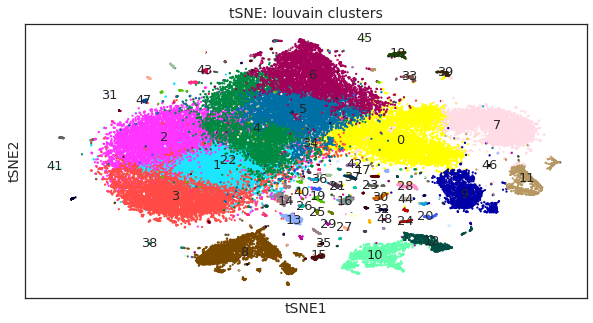

In [231]:
plt.figure(figsize=(10,5))
ax=plt.gca()

ax1=sc.pl.tsne(adata, color=['louvain_groups'], legend_loc='on data',title='tSNE: louvain clusters',ax=ax,size=20,show=False)

In [232]:
focus_on_group_labels=['3','1','4','5','6']

focus =[]
for i in labels:
    if i in focus_on_group_labels:
        focus+=['1']
    else:
        focus+=['0']
focus=np.array(focus)

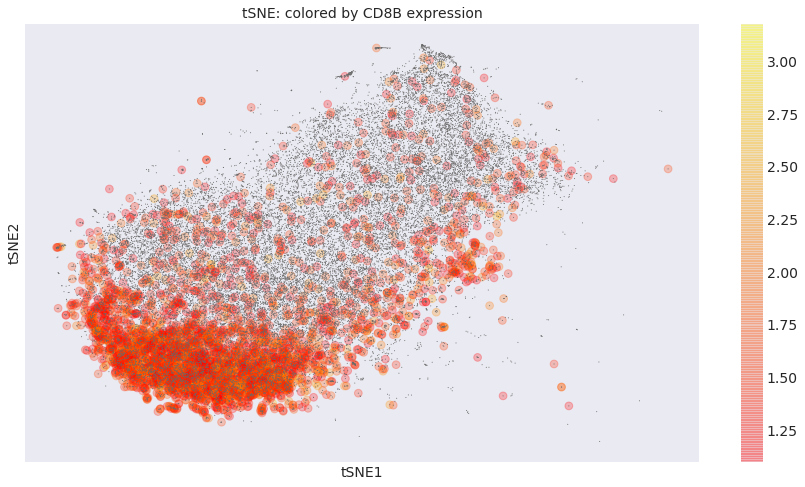

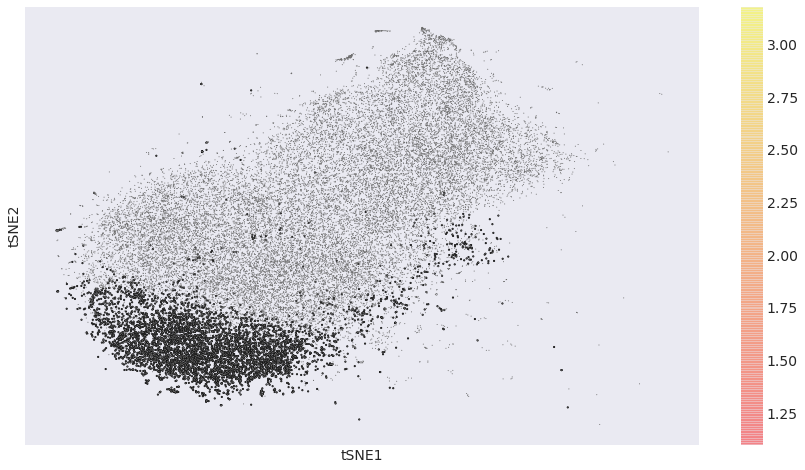

In [291]:
gene="CD8B"
Gexp=get_gene_counts(gene)
Gexp=Gexp[np.where(focus=='1')[0]]

fig=plt.figure(figsize=(15,8))
ax=plt.gca()

col=np.log(1+Gexp)
# mini=-0.101633
mini=1+np.median(col)
adtsne=adata.smp['X_tsne'][np.where(focus=='1')[0],:]
im=plt.scatter(adtsne[np.where(col>mini)[0],0],adtsne[np.where(col>mini)[0],1],s=60,alpha=0.25,c=col[np.where(col>mini)[0]],cmap='autumn')
ax1=sc.pl.tsne(adata[np.where(focus=='1')[0],:], color='dimgray', legend_loc='on data',title=['tSNE: colored by '+gene+' expression'],ax=ax,size=4,show=False)
fig.colorbar(im, cmap='autumn', orientation='vertical')




fig=plt.figure(figsize=(15,8))
ax=plt.gca()

col=np.log(1+Gexp)
# mini=-0.101633
mini=np.median(col)
adtsne=adata.smp['X_tsne'][np.where(focus=='1')[0],:]
# im=plt.scatter(adtsne[np.where(col>mini)[0],0],adtsne[np.where(col>mini)[0],1],s=60,alpha=0.15,c=col[np.where(col>mini)[0]],cmap='autumn')
ax1=sc.pl.tsne(adata[np.where(labels==cyto_id)[0],:], color='black', legend_loc='on data',title=['tSNE:  colored by '+gene+' expression'],ax=ax,size=18,show=False)
ax1=sc.pl.tsne(adata[np.where(focus=='1')[0],:], color='dimgray', legend_loc='on data',ax=ax,size=4,show=False)
fig.colorbar(im, cmap='autumn', orientation='vertical')

In [292]:
# ax1=sc.pl.tsne(adata[np.where(labels=='0')[0],:], color='black', legend_loc='on data',title=['tSNE: louvain clusters, colored by '+gene+' expression'],ax=ax,size=8,show=False)


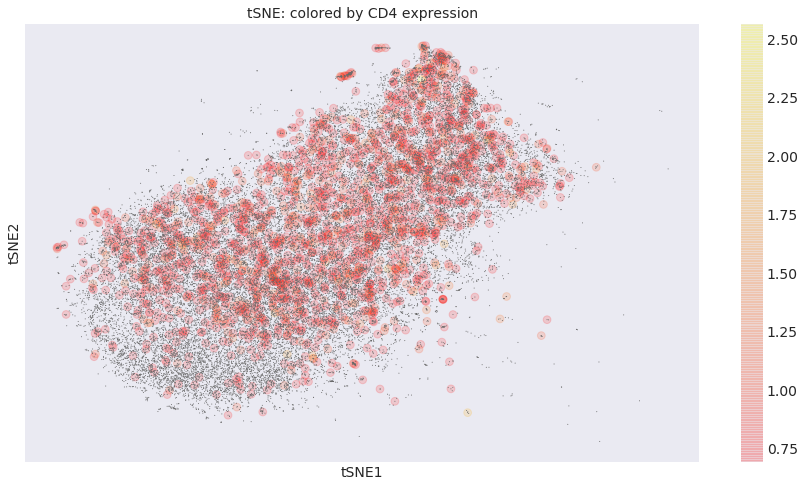

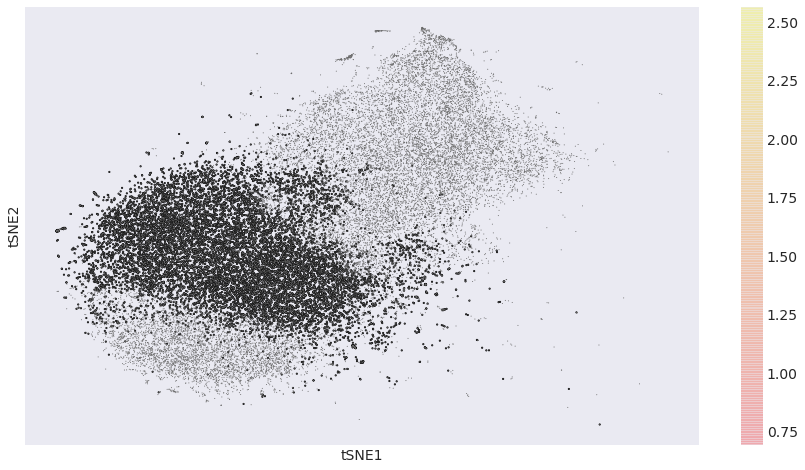

In [293]:
gene="CD4"
Gexp=get_gene_counts(gene)
Gexp=Gexp[np.where(focus=='1')[0]]

fig=plt.figure(figsize=(15,8))
ax=plt.gca()

col=np.log(1+Gexp)
# mini=-0.101633
mini=np.median(col)
adtsne=adata.smp['X_tsne'][np.where(focus=='1')[0],:]
im=plt.scatter(adtsne[np.where(col>mini)[0],0],adtsne[np.where(col>mini)[0],1],s=60,alpha=0.15,c=col[np.where(col>mini)[0]],cmap='autumn')
ax1=sc.pl.tsne(adata[np.where(focus=='1')[0],:], color='dimgray', legend_loc='on data',title=['tSNE: colored by '+gene+' expression'],ax=ax,size=4,show=False)
fig.colorbar(im, cmap='autumn', orientation='vertical')


fig=plt.figure(figsize=(15,8))
ax=plt.gca()

col=np.log(1+Gexp)
# mini=-0.101633
mini=np.median(col)
adtsne=adata.smp['X_tsne'][np.where(focus=='1')[0],:]
# im=plt.scatter(adtsne[np.where(col>mini)[0],0],adtsne[np.where(col>mini)[0],1],s=60,alpha=0.15,c=col[np.where(col>mini)[0]],cmap='autumn')
ax1=sc.pl.tsne(adata[np.where(labels==naive_id)[0],:], color='black', legend_loc='on data',title=['tSNE: louvain clusters, colored by '+gene+' expression'],ax=ax,size=18,show=False)
ax1=sc.pl.tsne(adata[np.where(focus=='1')[0],:], color='dimgray', legend_loc='on data',ax=ax,size=4,show=False)
fig.colorbar(im, cmap='autumn', orientation='vertical')

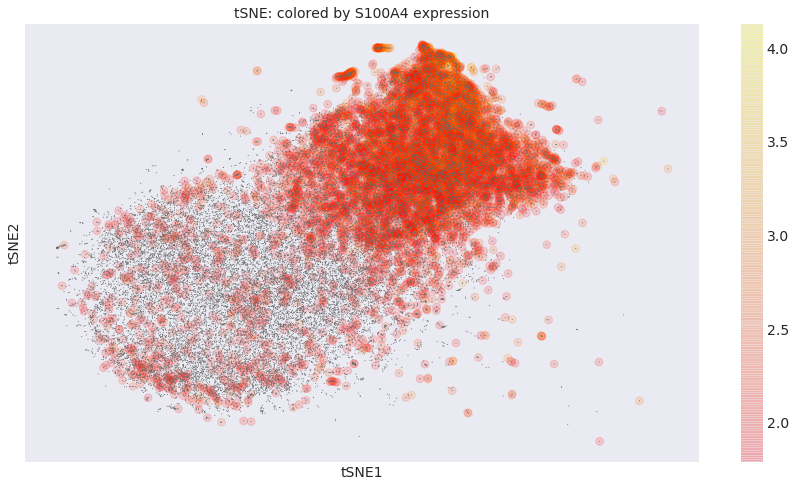

In [294]:
gene="S100A4"
Gexp=get_gene_counts(gene)
Gexp=Gexp[np.where(focus=='1')[0]]

fig=plt.figure(figsize=(15,8))
ax=plt.gca()

col=np.log(1+Gexp)
# mini=-0.101633
mini=1+np.median(col)
adtsne=adata.smp['X_tsne'][np.where(focus=='1')[0],:]
im=plt.scatter(adtsne[np.where(col>mini)[0],0],adtsne[np.where(col>mini)[0],1],s=60,alpha=0.15,c=col[np.where(col>mini)[0]],cmap='autumn')
ax1=sc.pl.tsne(adata[np.where(focus=='1')[0],:], color='dimgray', legend_loc='on data',title=['tSNE: colored by '+gene+' expression'],ax=ax,size=4,show=False)
fig.colorbar(im, cmap='autumn', orientation='vertical')


# fig=plt.figure(figsize=(15,8))
# ax=plt.gca()

# col=np.log(1+Gexp)
# # mini=-0.101633
# mini=np.median(col)
# adtsne=adata.smp['X_tsne'][np.where(focus=='1')[0],:]
# # im=plt.scatter(adtsne[np.where(col>mini)[0],0],adtsne[np.where(col>mini)[0],1],s=60,alpha=0.15,c=col[np.where(col>mini)[0]],cmap='autumn')
# ax1=sc.pl.tsne(adata[np.where(labels=='1')[0],:], color='black', legend_loc='on data',title=['tSNE: louvain clusters, colored by '+gene+' expression'],ax=ax,size=18,show=False)
# ax1=sc.pl.tsne(adata[np.where(focus=='1')[0],:], color='dimgray', legend_loc='on data',title=['tSNE: louvain clusters, colored by '+gene+' expression'],ax=ax,size=4,show=False)
# fig.colorbar(im, cmap='autumn', orientation='vertical')

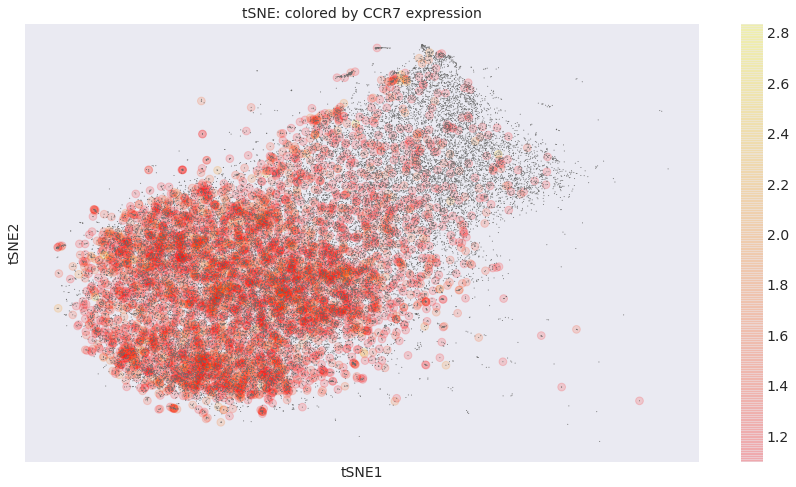

In [295]:
gene="CCR7"
Gexp=get_gene_counts(gene)
Gexp=Gexp[np.where(focus=='1')[0]]

fig=plt.figure(figsize=(15,8))
ax=plt.gca()

col=np.log(1+Gexp)
# mini=-0.101633
mini=1+np.median(col)
adtsne=adata.smp['X_tsne'][np.where(focus=='1')[0],:]
im=plt.scatter(adtsne[np.where(col>mini)[0],0],adtsne[np.where(col>mini)[0],1],s=60,alpha=0.15,c=col[np.where(col>mini)[0]],cmap='autumn')
ax1=sc.pl.tsne(adata[np.where(focus=='1')[0],:], color='dimgray', legend_loc='on data',title=['tSNE: colored by '+gene+' expression'],ax=ax,size=4,show=False)
fig.colorbar(im, cmap='autumn', orientation='vertical')


# fig=plt.figure(figsize=(15,8))
# ax=plt.gca()

# col=np.log(1+Gexp)
# # mini=-0.101633
# mini=np.median(col)
# adtsne=adata.smp['X_tsne'][np.where(focus=='1')[0],:]
# # im=plt.scatter(adtsne[np.where(col>mini)[0],0],adtsne[np.where(col>mini)[0],1],s=60,alpha=0.15,c=col[np.where(col>mini)[0]],cmap='autumn')
# ax1=sc.pl.tsne(adata[np.where(labels=='1')[0],:], color='black', legend_loc='on data',title=['tSNE: louvain clusters, colored by '+gene+' expression'],ax=ax,size=18,show=False)
# ax1=sc.pl.tsne(adata[np.where(focus=='1')[0],:], color='dimgray', legend_loc='on data',title=['tSNE: louvain clusters, colored by '+gene+' expression'],ax=ax,size=4,show=False)
# fig.colorbar(im, cmap='autumn', orientation='vertical')

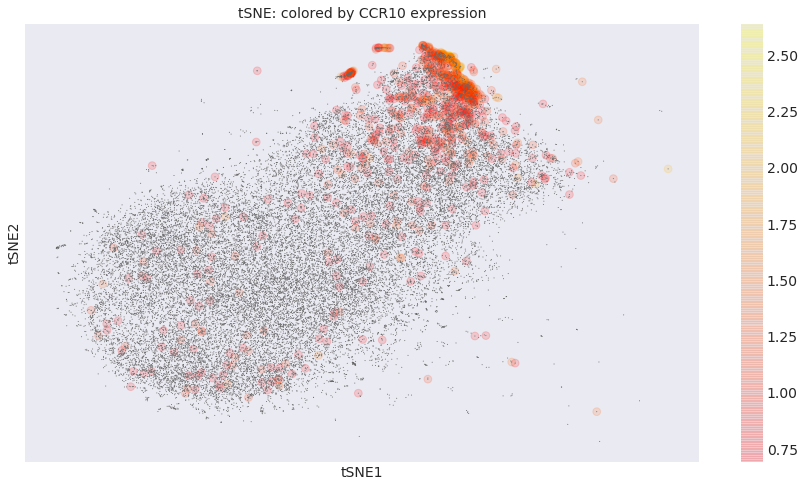

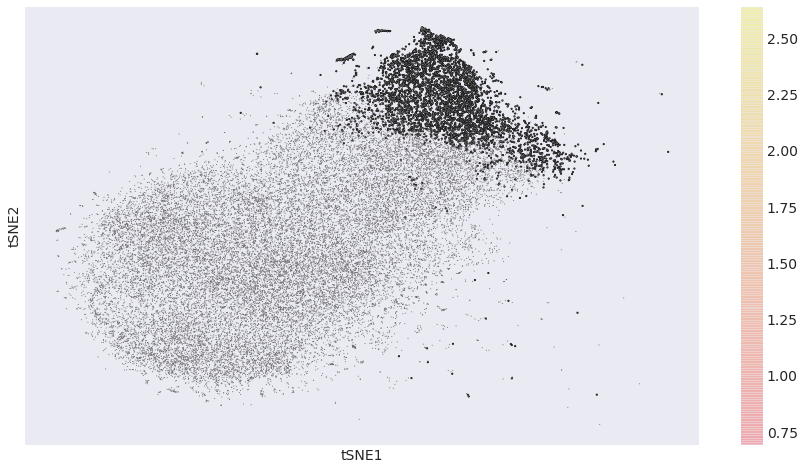

In [299]:
gene="CCR10"
Gexp=get_gene_counts(gene)
Gexp=Gexp[np.where(focus=='1')[0]]

fig=plt.figure(figsize=(15,8))
ax=plt.gca()

col=np.log(1+Gexp)
# mini=-0.101633
mini=np.median(col)
adtsne=adata.smp['X_tsne'][np.where(focus=='1')[0],:]
im=plt.scatter(adtsne[np.where(col>mini)[0],0],adtsne[np.where(col>mini)[0],1],s=60,alpha=0.15,c=col[np.where(col>mini)[0]],cmap='autumn')
ax1=sc.pl.tsne(adata[np.where(focus=='1')[0],:], color='dimgray', legend_loc='on data',title=['tSNE: colored by '+gene+' expression'],ax=ax,size=4,show=False)
fig.colorbar(im, cmap='autumn', orientation='vertical')


fig=plt.figure(figsize=(15,8))
ax=plt.gca()

col=np.log(1+Gexp)
# mini=-0.101633
mini=np.median(col)
adtsne=adata.smp['X_tsne'][np.where(focus=='1')[0],:]
# im=plt.scatter(adtsne[np.where(col>mini)[0],0],adtsne[np.where(col>mini)[0],1],s=60,alpha=0.15,c=col[np.where(col>mini)[0]],cmap='autumn')
ax1=sc.pl.tsne(adata[np.where(labels==mem_id)[0],:], color='black', legend_loc='on data',title=['tSNE: colored by '+gene+' expression'],ax=ax,size=18,show=False)
ax1=sc.pl.tsne(adata[np.where(focus=='1')[0],:], color='dimgray', legend_loc='on data',ax=ax,size=4,show=False)
fig.colorbar(im, cmap='autumn', orientation='vertical')

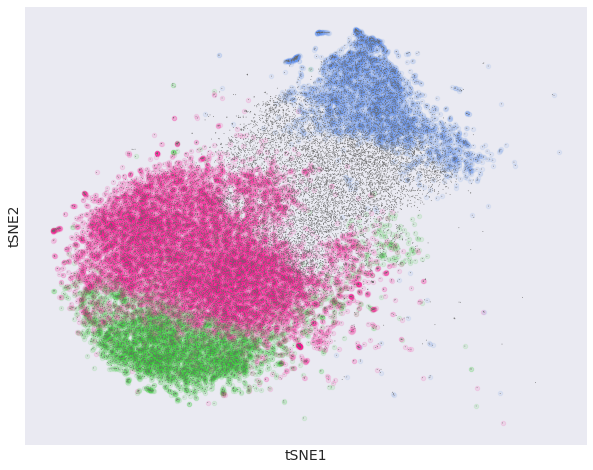

In [297]:
fig=plt.figure(figsize=(10,8))
ax=plt.gca()

adtsne=adata.smp['X_tsne']
im=plt.scatter(adtsne[np.where(labels==cyto_id)[0],0],adtsne[np.where(labels==cyto_id)[0],1],s=20,alpha=0.1,c='limegreen')
im=plt.scatter(adtsne[np.where(labels==naive_id)[0],0],adtsne[np.where(labels==naive_id)[0],1],s=20,alpha=0.1,c='deeppink')

im=plt.scatter(adtsne[np.where(labels==mem_id)[0],0],adtsne[np.where(labels==mem_id)[0],1],s=20,alpha=0.1,c='cornflowerblue')

ax1=sc.pl.tsne(adata[np.where(focus=='1')[0],:], color='dimgray', legend_loc='on data',ax=ax,size=3,show=False)
# fig.colorbar(im, cmap='autumn', orientation='vertical')